In [ ]:
!pip install transformers==4.28.0
!pip install --upgrade accelerate

In [5]:
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
le = LabelEncoder()

In [8]:
train_dataset = pd.read_csv('datasets/train_level_a.csv')
train_dataset

,id,tweet,subtask_a
0,86426,@USER She should ask a few native Americans wh...,OFF
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,16820,Amazon is investigating Chinese employees who ...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT
...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT
13237,82921,@USER And why report this garbage. We don't g...,OFF
13238,27429,@USER Pussy,OFF


In [9]:
tokenized_data = tokenizer(train_dataset["tweet"].tolist(), return_tensors="np", padding=True)
tokenized_data = dict(tokenized_data)
labels = np.array(le.fit_transform(train_dataset["subtask_a"]))

In [10]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'NOT': 0, 'OFF': 1}


In [11]:
with tf.device(device_name):
  model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
  model.compile(optimizer=Adam(3e-5))
model.fit(tokenized_data, labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


414/414 [==============================] - 491s 1s/step - loss: 0.4616


In [12]:
model.save_pretrained("models/bert")

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("models/bert")

In [14]:
test_dataset = pd.read_csv('datasets/test_level_a.csv')
test_dataset

,id,tweet,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF
...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT


In [15]:
tweets = test_dataset['tweet']
y_true = le.fit_transform(test_dataset['label'])

In [16]:
tokenized = tokenizer(tweets.tolist(), return_tensors="np", padding="longest")
outputs = model(tokenized).logits

y_pred = np.argmax(outputs, axis=1)

In [17]:
def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_names = le.classes_ # name  of classes
    fig, ax = plt.subplots()
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels');

              precision    recall  f1-score   support

         NOT     0.8701    0.9290    0.8986       620
         OFF     0.7778    0.6417    0.7032       240

    accuracy                         0.8488       860
   macro avg     0.8239    0.7853    0.8009       860
weighted avg     0.8443    0.8488    0.8441       860


accuracy: 0.8488372093023255
macro F1: 0.8008961454348585
weighted F1: 0.8440658237989284



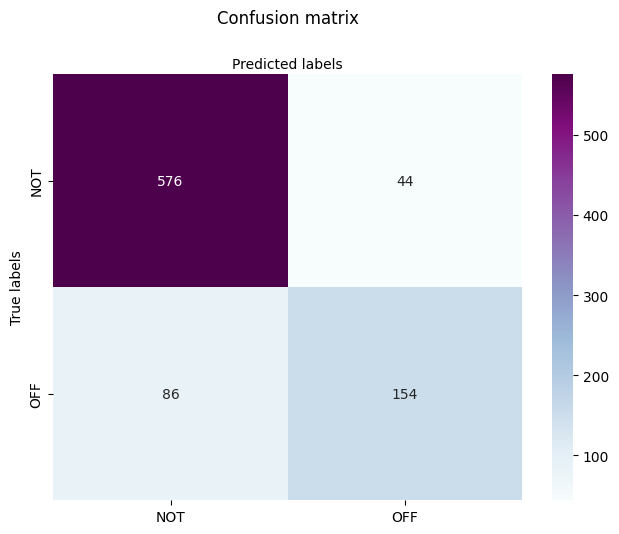

In [18]:
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))
print()
print("accuracy:", accuracy_score(y_true, y_pred))
print("macro F1:", f1_score(y_true, y_pred, average='macro'))
print("weighted F1:", f1_score(y_true, y_pred, average='weighted'))
print()
plot_conf_matrix(y_true, y_pred)

In [19]:
true_labels = le.inverse_transform(y_true)
bert_labels = le.inverse_transform(y_pred)

In [21]:
predictions_file = pd.read_csv('predictions.csv')
predictions_file

,id,tweet,true_label,bert_label,gpt_label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,NOT,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NOT,NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NOT,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT,NOT,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,NOT,NOT
...,...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,NOT,NOT
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,NOT,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF,OFF,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,OFF,NOT


In [23]:
predictions_file['bert_label'] = bert_labels
predictions_file

,id,tweet,true_label,bert_label,gpt_label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,NOT,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NOT,NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NOT,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT,NOT,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,NOT,NOT
...,...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,NOT,NOT
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,NOT,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF,OFF,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,OFF,NOT


In [24]:
predictions_file.to_csv('predictions.csv', index=False)